In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.utils.data
from torch.utils.data.sampler import SubsetRandomSampler

import os
import h5py
import matplotlib.pyplot as plt
os.environ['CUDA_VISIBLE_DEVICES'] = "1"
from time import time

import FrEIA.framework  as Ff
import FrEIA.modules as Fm

import losses
import monitoring
from  utils import ScatteringProblemSplit
from visualizations import plot_outcomes_identified, describe_false_shapes, describe_positive_shapes


In [2]:
# this parameters work when I/100
filename_out    = 'output/inn_RNVP_split.pt'
# Model to load and continue training. Ignored if empty string
filename_in     = ''
# Compute device to perform the training on, 'cuda' or 'cpu'
device          = 'cuda'
# Use interactive visualization of losses and other plots. Requires visdom
interactive_visualization = False # check first how this visdom works
# Run a list of python functions at test time after eacch epoch
# See toy_modes_train.py for reference example
test_time_functions = []

#######################
#  Training schedule  #
#######################

# Initial learning rate
lr_init         = 5e-3
#Batch size
batch_size      = 128
# Total number of epochs to train for
n_epochs        = 100

# End the epoch after this many iterations (or when the train loader is exhausted)
n_its_per_epoch = 200
# For the first n epochs, train with a much lower learning rate. This can be
# helpful if the model immediately explodes.
pre_low_lr      = 0
# Decay exponentially each epoch, to final_decay*lr_init at the last epoch.
final_decay     = 0.02
# L2 weight regularization of model parameters
l2_weight_reg   = 1e-5
# Parameters beta1, beta2 of the Adam optimizer
adam_betas = (0.9, 0.95)

#####################
#  Data dimensions  #
#####################
ndim_x_class     = 3
ndim_pad_x_class = 200
ndim_x_features     = 7
ndim_pad_x_features = 404

ndim_y     = 512
ndim_z     = 2
ndim_pad_zy = 100 


# Overwrite or import data loaders here.
# See dkfz_train.py for reference.
#from my_loaders import train_loader, test_loader

train_loader, test_loader = None, None

assert (ndim_x_class + ndim_x_features + ndim_pad_x_class+ ndim_pad_x_features 
        == ndim_y + ndim_z + ndim_pad_zy), "Dimensions don't match up"

############
#  Losses  #
############

train_forward_mmd    = True
train_backward_mmd   = True
train_reconstruction = True
train_max_likelihood = False


lambd_fit_forw         = 0.1
lambd_mmd_forw         = 50
lambd_reconstruct      = 1
lambd_mmd_back_class   = 100
lambd_mmd_back_feature = 500

# Both for fitting, and for the reconstruction, perturb y with Gaussian 
# noise of this sigma
add_y_noise     = 0 # think of smth smart here
# For reconstruction, perturb z 
add_z_noise     = 2e-2
# In all cases, perturb the zero padding
add_pad_noise   = 1e-2

# For noisy forward processes, the sigma on y (assumed equal in all dimensions).
# This is only used if mmd_back_weighted of train_max_likelihoiod are True.
y_uncertainty_sigma = 0.12 * 43
mmd_forw_kernels = [(0.2, 1/2), (1.5, 1/2), (3.0, 1/2)]
mmd_back_kernels = [(0.2, 1/2), (0.2, 1/2), (0.2, 1/2)]
mmd_back_weighted = True

###########
#  Model  #
###########

# Initialize the model parameters from a normal distribution with this sigma
init_scale = 0.10
#
N_blocks   = 5
#
exponent_clamping = 1.
#
hidden_layer_sizes = 32
#
use_permutation = True
#
verbose_construction = False

device = 'cuda'

In [3]:
learning_problem = ScatteringProblemSplit(device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [4]:
learning_problem.read_data('/home/slaskina/simulations')


In [5]:
learning_problem.normalize_inputs()

In [6]:
learning_problem.update_hyperparameters(device,  batch_size, ndim_x_class, ndim_x_features, ndim_y, ndim_z, ndim_pad_x_class, ndim_pad_x_features,
                       ndim_pad_zy, init_scale, final_decay, n_epochs, lr_init, adam_betas, l2_weight_reg, lambd_fit_forw, 
                       lambd_mmd_forw, lambd_mmd_back_class, lambd_mmd_back_feature, lambd_reconstruct, mmd_back_weighted, 
                       y_uncertainty_sigma, add_pad_noise, add_z_noise, add_y_noise, n_its_per_epoch, pre_low_lr, filename_out, mmd_forw_kernels, mmd_back_kernels)

In [7]:
learning_problem.create_loaders()

In [8]:
def subnet2(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))


def subnet1(dims_in, dims_out):
    return nn.Sequential(nn.Linear(dims_in, hidden_layer_sizes*2), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes*2,  hidden_layer_sizes), nn.ReLU(),
                        nn.Linear(hidden_layer_sizes,  dims_out))

input1 = Ff.InputNode(ndim_x_class + ndim_pad_x_class, name='input_class')
input2 = Ff.InputNode(ndim_x_features + ndim_pad_x_features, name='input_features')


nodes = [input1]
for i in range(N_blocks//2):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet1, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))

nodes.append(input2)
nodes.append( Ff.Node([nodes[-2].out0, nodes[-1].out0], Fm.Concat, {}, name='Concat'))
for i in range(N_blocks):
    nodes.append(Ff.Node(nodes[-1].out0, Fm.RNVPCouplingBlock, {'subnet_constructor':subnet2, 'clamp':exponent_clamping}, name = 'coupling_{}'.format(i)))
    if use_permutation:
        nodes.append(Ff.Node([nodes[-1].out0], Fm.PermuteRandom, {'seed':i}, name='permute_{}'.format(i)))

nodes.append(Ff.OutputNode([nodes[-1].out0], name='output'))
model = Ff.GraphINN(nodes, verbose=verbose_construction)


In [9]:
learning_problem.set_model(model)
learning_problem.set_optimizer()

In [10]:
learning_problem.train()

Epoch            L_fit       L_mmd_fwd      L_mmd_back       L_reconst     L_fit(test) L_mmd_fwd(test) L_mmd_back(test) L_reconst(test)
   000          8.3322          0.4800          1.3254          7.8209          0.2755          1.3197
   001          7.5883          0.2835          1.3174          7.5437          0.2797          1.3138
   002          7.3491          0.2775          1.3155          7.2571          0.2777          1.3135
   003          7.4101          0.2760          1.3131          7.2528          0.2698          1.3135
   004          7.3195          0.2733          1.3155          7.2193          0.2711          1.3132
   005          7.2457          0.2736          1.3139          7.2252          0.2669          1.3118
   006          6.8982          0.2691          1.3118          6.6910          0.2669          1.3094
   007          6.6432          0.2698          1.3099          6.4865          0.2679          1.3096
   008          6.5919          0.2648  

In [11]:
df_train = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.train_indices), learning_problem.train_indices)
df_val = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.val_indices), learning_problem.val_indices) 
df_test = learning_problem.create_table_from_outcomes(learning_problem.make_prediction(learning_problem.test_indices), learning_problem.test_indices)

Accuracy is 89.68%
MSE for radius per shape for correctly identified instances as follows: sphere: 719.9295, hardsphere: 5738.6880 and cylinder: 768.8904
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0070, hardsphere: 0.0020 and cylinder: 0.0336
MSE for cylinder length for correctly identified instances: 15032.8145
MSE for cylinder length polydispersity for correctly identified instances: 1.6099
MSE for cylinder length for correctly identified instances: 0.0688


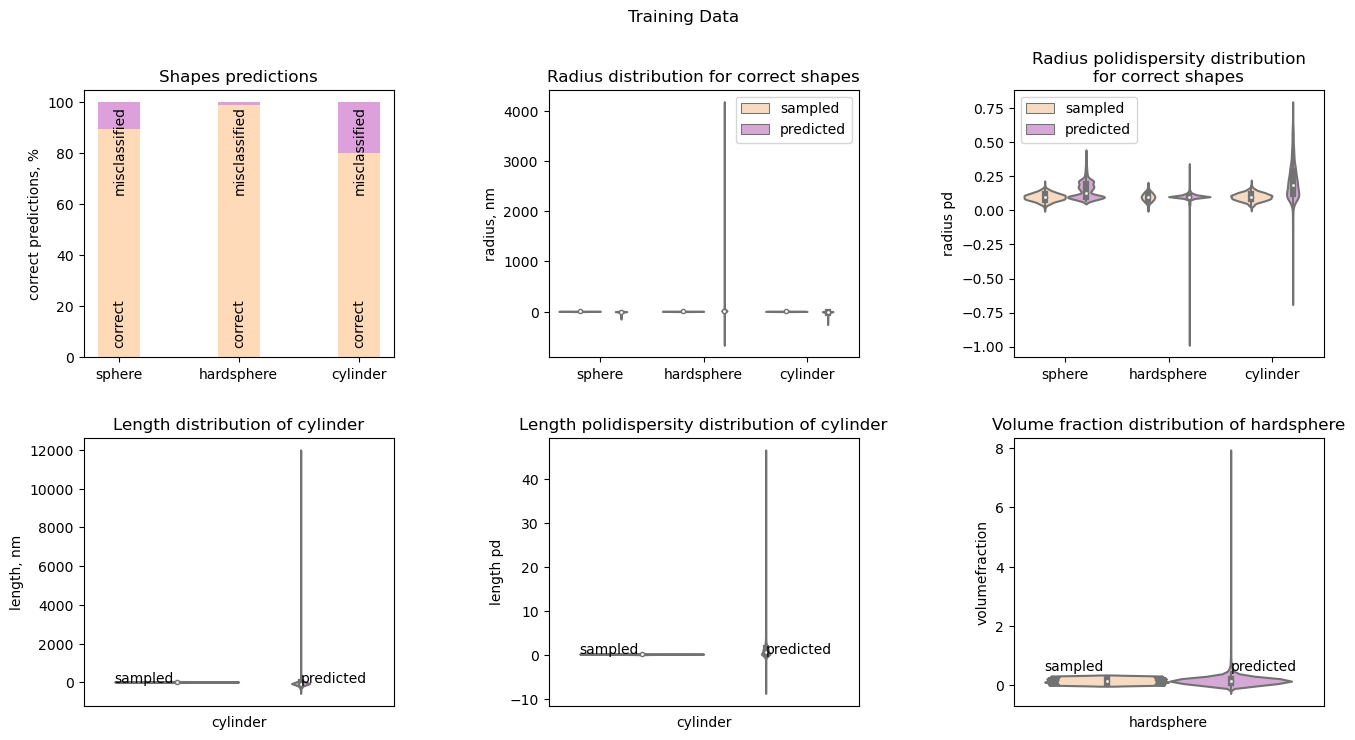

In [12]:
plot_outcomes_identified(df_train, 'Training')

Accuracy is 89.53%
MSE for radius per shape for correctly identified instances as follows: sphere: 640.4362, hardsphere: 359.1089 and cylinder: 751.1049
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0064, hardsphere: 0.0015 and cylinder: 0.0363
MSE for cylinder length for correctly identified instances: 14866.2959
MSE for cylinder length polydispersity for correctly identified instances: 1.7052
MSE for cylinder length for correctly identified instances: 0.0532


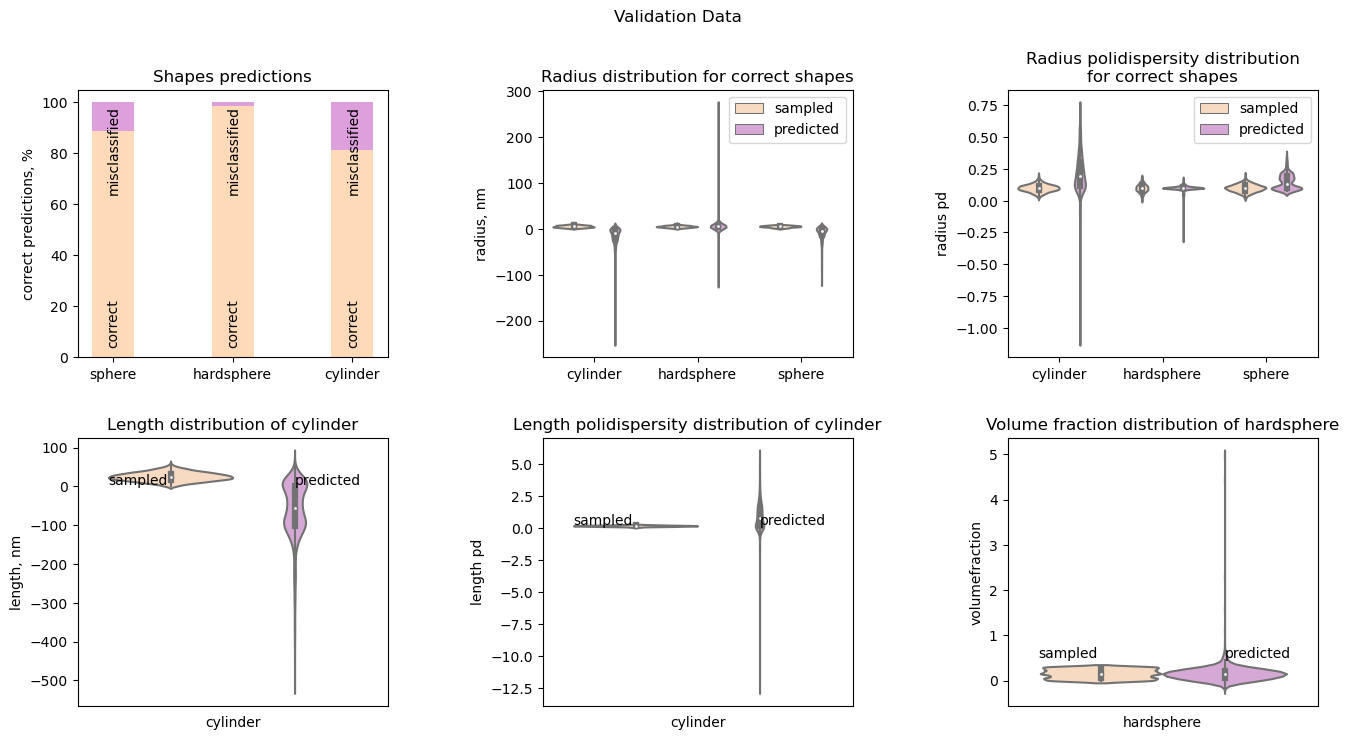

In [13]:
plot_outcomes_identified(df_val, 'Validation')

Accuracy is 89.73%
MSE for radius per shape for correctly identified instances as follows: sphere: 591.9897, hardsphere: 375.6906 and cylinder: 679.4879
MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: 0.0061, hardsphere: 0.0012 and cylinder: 0.0303
MSE for cylinder length for correctly identified instances: 13567.6328
MSE for cylinder length polydispersity for correctly identified instances: 1.4582
MSE for cylinder length for correctly identified instances: 0.0131


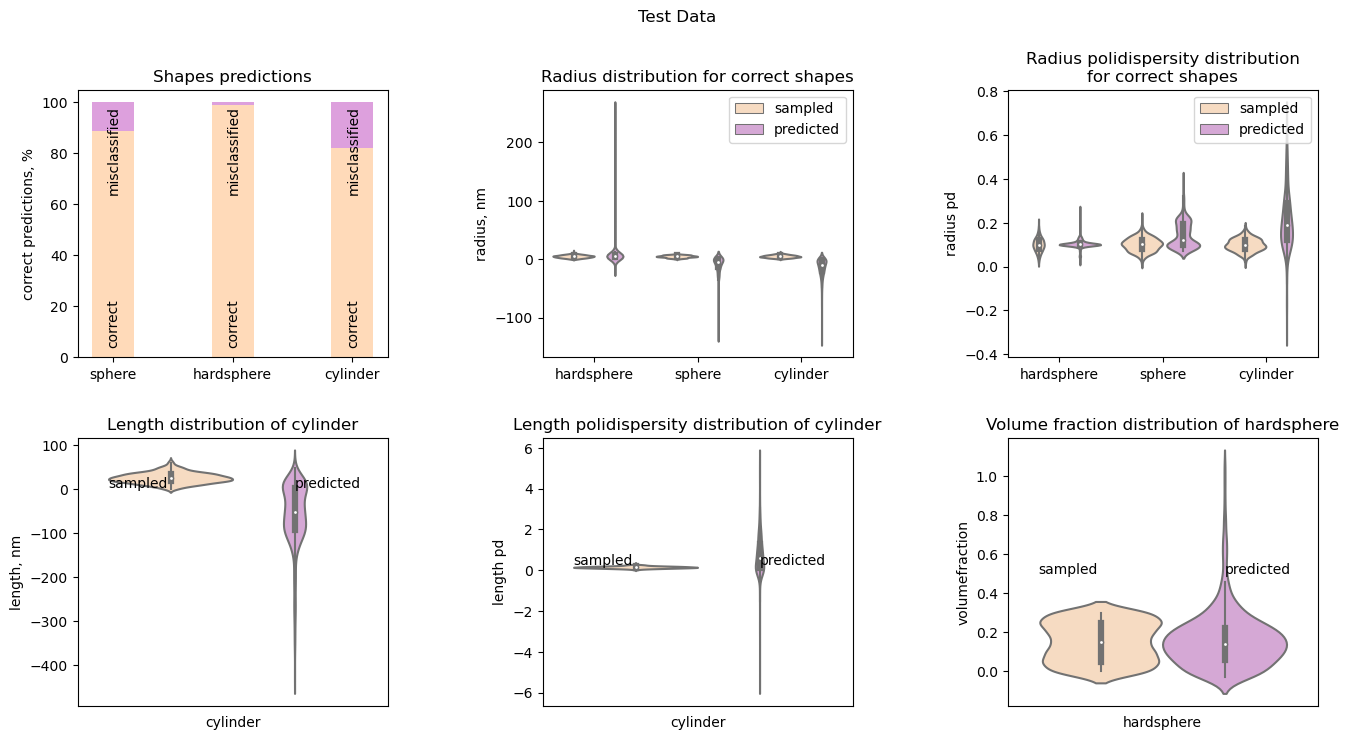

In [14]:
plot_outcomes_identified(df_test, 'Test')

In [15]:
df_test

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
0,1,1,4.521623,3.711864,0.137957,0.099518,0.000000,5.238256,0.000000,-0.012272,0.20,0.173697
1,2,0,7.016451,-58.336250,0.110119,0.260926,15.069812,-93.424141,0.166154,0.562107,0.00,0.026730
2,2,2,6.242439,-11.790637,0.104703,0.326682,23.140541,-81.155609,0.257852,0.933418,0.00,0.212429
3,2,2,8.598413,-8.385355,0.146229,0.290131,10.450610,-87.382156,0.118462,0.837787,0.00,0.033330
4,1,1,5.372845,4.685643,0.139639,0.097848,0.000000,4.118627,0.000000,0.022246,0.05,0.056879
...,...,...,...,...,...,...,...,...,...,...,...,...
1495,1,1,0.215263,2.805033,0.103530,0.124792,0.000000,0.508041,0.000000,-0.087501,0.30,0.013284
1496,0,0,7.928937,-29.605879,0.070772,0.226195,0.000000,-96.521667,0.000000,0.226748,0.00,-0.064985
1497,2,2,2.721311,-14.602188,0.158766,0.115700,34.106861,0.215714,0.126336,-0.140229,0.00,0.062840
1498,0,0,6.885484,-16.892761,0.064197,0.203901,0.000000,-50.126530,0.000000,-0.320343,0.00,-0.140760


In [16]:
false_shapes = df_test[df_test.true_shape != df_test.pred_shape]

FN_spheres = false_shapes[false_shapes.true_shape == 0]
FP_spheres = false_shapes[false_shapes.pred_shape == 0]
false_spheres = pd.concat([FN_spheres, FP_spheres])

FN_hardspheres = false_shapes[false_shapes.true_shape == 1]
FP_hardspheres = false_shapes[false_shapes.pred_shape == 1]
false_hardspheres = pd.concat([FN_hardspheres, FP_hardspheres])

FN_cylinders = false_shapes[false_shapes.true_shape == 2]
FP_cylinders = false_shapes[false_shapes.pred_shape == 2]
false_cylinders = pd.concat([FN_cylinders, FP_cylinders])

In [17]:
false_spheres

,true_shape,pred_shape,radius,pred_radius,radius_pd,pred_radius_pd,length,pred_length,length_pd,pred_length_pd,volfraction,pred_volfraction
5,0,2,9.231373,-13.147769,0.097835,0.368269,0.000000,-113.625496,0.000000,1.234056,0.0,0.104332
27,0,2,10.730081,-33.251945,0.106823,0.618294,0.000000,-115.731049,0.000000,2.451658,0.0,0.749062
28,0,2,3.115986,0.323374,0.103291,0.085190,0.000000,20.659868,0.000000,-0.095881,0.0,0.118763
160,0,2,3.135195,0.713087,0.131757,0.090498,0.000000,19.408430,0.000000,-0.069304,0.0,0.073428
171,0,2,2.853204,-0.264517,0.124048,0.085865,0.000000,22.240913,0.000000,-0.121629,0.0,0.161777
...,...,...,...,...,...,...,...,...,...,...,...,...
1389,2,0,7.474367,-37.376049,0.104085,0.216466,10.739079,-83.752754,0.192647,0.364447,0.0,0.008144
1401,2,0,3.773635,-3.316100,0.066697,0.113902,10.246267,-7.120577,0.159169,-0.176091,0.0,0.023233
1444,2,0,4.181431,-1.164359,0.154837,0.108301,6.579936,-3.168236,0.169228,-0.152927,0.0,0.028177
1472,2,0,3.973353,-4.088742,0.085407,0.139649,13.119872,-16.126125,0.189344,-0.056700,0.0,-0.130950


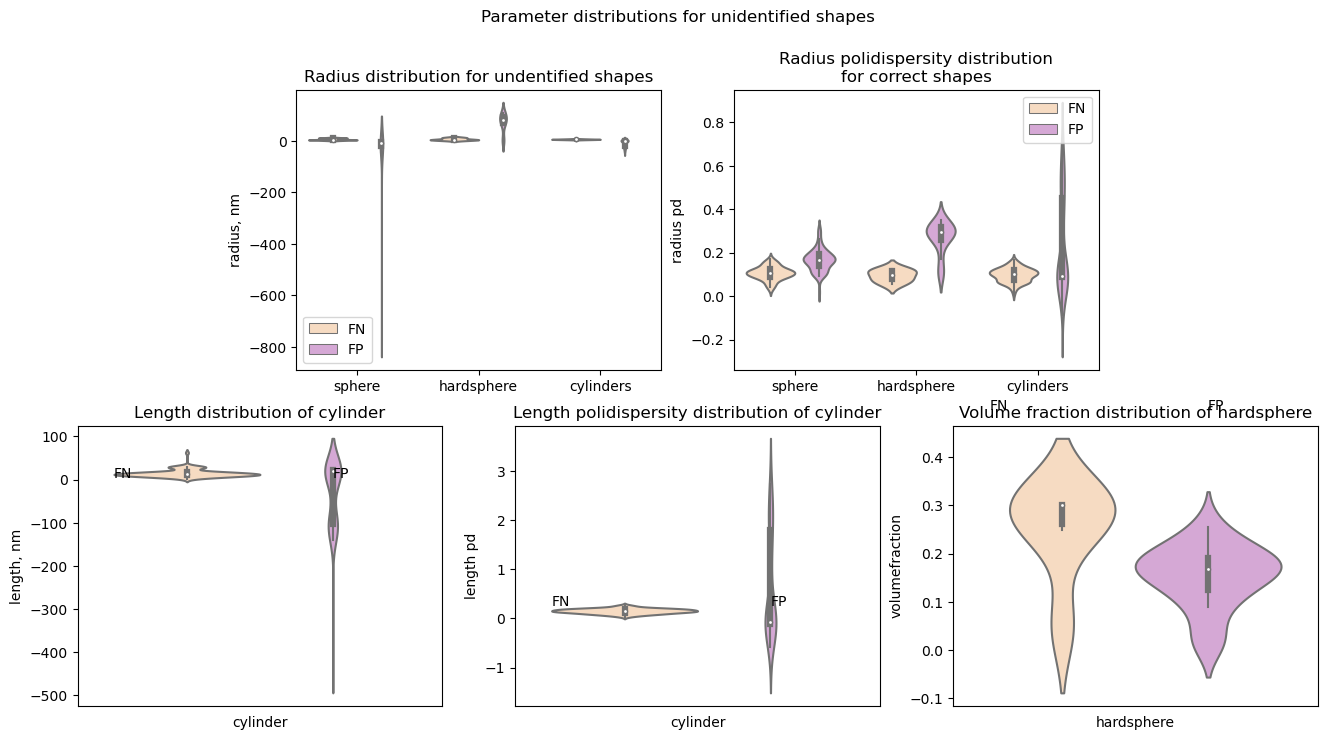

In [18]:
describe_false_shapes(false_spheres, false_hardspheres, false_cylinders)

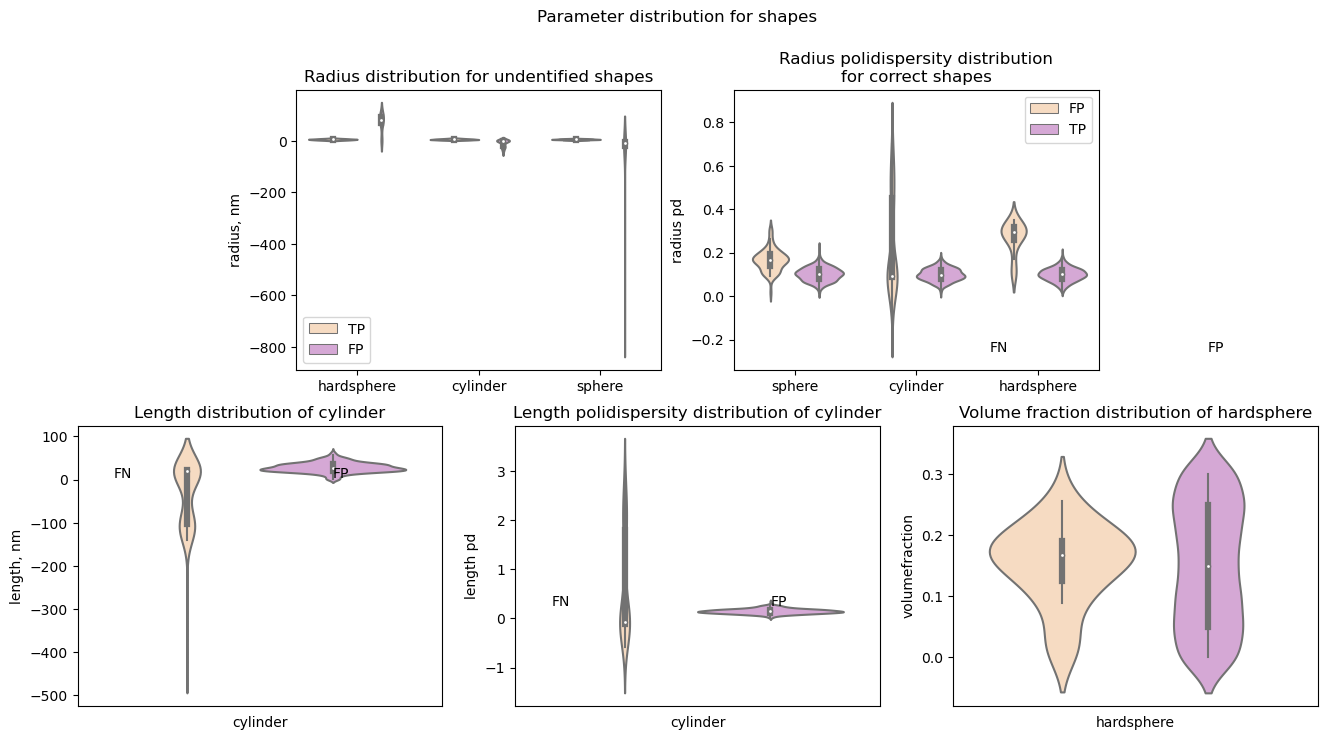

In [19]:
describe_positive_shapes(df_test)

In [20]:
import seaborn as sns
from sklearn.metrics import mean_squared_error
def MSE(sampled, predicted):
    if len(sampled) == 0:
        return np.inf
    else:
        return mean_squared_error(sampled, predicted)

def set_value(row, true_shape, colname_true, colname_pred):
    if row.true_shape == true_shape:
        return row[colname_true]
    else:
        return row[colname_pred]
def set_label(row, true_shape, label_true, label_false):
    if row.true_shape == true_shape:
        return label_true
    else:
        return label_false


def plot_outcomes_identified(df, data_name):
    print('Accuracy is {0:.2%}'.format((df.true_shape == df.pred_shape).sum()/len(df)))
    fig, axes = plt.subplots(ncols=3, nrows=2, figsize=(16, 8))
    fig.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=0.5, hspace=0.3)
    shapes = ['sphere', 'hardsphere', 'cylinder']
    # shape classified correctly
    correct = [((df.true_shape == 0) & (df.pred_shape == 0)).sum(),((df.true_shape == 1) & (df.pred_shape == 1)).sum(),((df.true_shape == 2) & (df.pred_shape == 2)).sum()]
    wrong = [((df.true_shape == 0) & (df.pred_shape != 0)).sum(),((df.true_shape == 1) & (df.pred_shape != 1)).sum(),((df.true_shape == 2) & (df.pred_shape != 2)).sum()]
    correct = [correct[i]/(correct[i]+ wrong[i])*100 for i in range(len(correct))]
    wrong = [100-correct[i] for i in range(len(wrong))]
    ax = axes[0,0]
    ax.bar(shapes, correct, width=0.35, label='correct', color = 'peachpuff')
    ax.bar(shapes, wrong, width=0.35,bottom=correct, label='misclassified', color = 'plum')
    ax.set_ylabel('correct predictions, %')
    ax.set_title('Shapes predictions')
    ax.text(-0.05, 5, 'correct', rotation = 90)
    ax.text(0.95, 5, 'correct', rotation = 90)
    ax.text(1.95, 5, 'correct', rotation = 90)
    
    ax.text(-0.05, 65, 'misclassified', rotation = 90)
    ax.text(0.95, 65, 'misclassified', rotation = 90)
    ax.text(1.95, 65, 'misclassified', rotation = 90)

    # radius of a correctly identified shapes
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius)))
      
    #print('Total radius MSE is {err:.2f}'.format(err= mean_squared_error(df.radius, df.pred_radius)))
    print('MSE for radius polydispersity per shape for correctly identified instances as follows: sphere: {sMSE:.4f}, hardsphere: {hsMSE:.4f} and cylinder: {cMSE:.4f}'.format\
        (sMSE = MSE(df[(df.true_shape == 0) & (df.pred_shape == 0)].radius_pd, df[(df.true_shape == 0) & (df.pred_shape == 0)].pred_radius_pd), 
         hsMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].radius_pd, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_radius_pd),
         cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].radius_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_radius_pd)))

    print('MSE for cylinder length for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length)))
    print('MSE for cylinder length polydispersity for correctly identified instances: {cMSE:.4f}'.format\
        (cMSE = MSE(df[(df.true_shape == 2) & (df.pred_shape == 2)].length_pd, df[(df.true_shape == 2) & (df.pred_shape == 2)].pred_length_pd)))
    print('MSE for cylinder length for correctly identified instances: {hMSE:.4f}'.format\
        (hMSE = MSE(df[(df.true_shape == 1) & (df.pred_shape == 1)].volfraction, df[(df.true_shape == 1) & (df.pred_shape == 1)].pred_volfraction)))
    #stacked df to create violinplots
    df_stacked = df[df.true_shape ==df.pred_shape].drop(columns = ['pred_shape']).set_index('true_shape').stack().reset_index().rename(columns = {'level_1':'feature', 0:'value'})
    df_stacked.loc[df_stacked.true_shape == 0, 'true_shape'] = "sphere"
    df_stacked.loc[df_stacked.true_shape == 1, 'true_shape'] = "hardsphere"
    df_stacked.loc[df_stacked.true_shape == 2, 'true_shape'] = "cylinder"

    ax = axes[0,1]
    data = df_stacked[(df_stacked.feature == 'radius')|(df_stacked.feature == 'pred_radius')]
    data.loc[data.feature == 'radius', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius distribution for correct shapes')
    ax.set_ylabel("radius, nm")
    ax.set_xlabel("")
    ax.legend()
    ax.set_ylim([-2, 2])

    ax = axes[0,2]
    data = df_stacked[(df_stacked.feature == 'radius_pd')|(df_stacked.feature == 'pred_radius_pd')]
    data.loc[data.feature == 'radius_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_radius_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="true_shape", y="value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Radius polidispersity distribution\nfor correct shapes')
    ax.legend()
    ax.set_ylabel("radius pd")
    ax.set_xlabel("")
    ax.set_ylim([-1, 1])

    # length
    df_stacked = df.set_index(['true_shape', 'pred_shape']).stack().reset_index().rename(columns = {'level_2':'feature', 0:'value'}).assign(y=1)

    ax = axes[1,0]
    data = df_stacked[((df_stacked.feature == 'length')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature",split = False, ax=ax, palette=['peachpuff', 'plum'] )
    ax.set_title('Length distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length, nm")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 4.2, "sampled")
    ax.text(0.2, 4.2, "predicted")
    ax.set_ylim([-2,5])

    ax = axes[1,1]
    data = df_stacked[((df_stacked.feature == 'length_pd')&(df_stacked.true_shape ==2))|((df_stacked.feature == 'pred_length_pd')&(df_stacked.pred_shape == 2))]
    data.loc[data.feature == 'length_pd', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_length_pd', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False),  x="y",y = "value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Length polidispersity distribution of cylinder')
    ax.set_xlabel("cylinder")
    ax.set_ylabel("length pd")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.25, "sampled")
    ax.text(0.2, 0.25, "predicted")
    ax.set_ylim([-1, 2])

    ax = axes[1,2]
    data = df_stacked[((df_stacked.feature == 'volfraction')&(df_stacked.true_shape ==1))|((df_stacked.feature == 'pred_volfraction')&(df_stacked.pred_shape == 1))]
    data.loc[data.feature == 'volfraction', 'feature'] = "sampled"
    data.loc[data.feature == 'pred_volfraction', 'feature'] = "predicted"
    sns.violinplot(data = data.sort_values(by = 'feature', ascending = False), x="y",y = "value", hue="feature", split = False, ax=ax, palette=['peachpuff', 'plum'])
    ax.set_title('Volume fraction distribution of hardsphere')
    ax.set_xlabel("hardsphere")
    ax.set_ylabel("volumefraction")
    ax.set_xticks([])
    ax.get_legend().remove()
    ax.text(-.4, 0.5, "sampled")
    ax.text(0.2, 0.5, "predicted")
    ax.set_ylim([-2, 2])

    plt.suptitle('{d} Data'.format(d = data_name))

## now look at the unidentified shapes more closely

In [21]:
def assign_class(row):
    if row[0]==1:
        return  'sphere'
    elif row[1] == 1:
        return 'hardsphere'
    elif row[2] == 1:
        return 'cylinder'
shapes_dict = {0:'sphere', 1:'hardsphere', 2:'cylinder'}

In [22]:
prediction_class = pd.DataFrame(make_prediction(labels[test_indices], model)[:,0:3])
prediction_class['true_class'] = pd.DataFrame(inputs[test_indices][:,0:3]).apply(assign_class, axis=1)
prediction_class['prediction'] = prediction_class[[0,1,2]].idxmax(axis=1)
prediction_class.replace({'prediction':shapes_dict}, inplace = True)

NameError: name 'make_prediction' is not defined

In [ ]:
unidentified_shapes = prediction_class[prediction_class.true_class != prediction_class.prediction]

In [ ]:
# shardpheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[2] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

Empty DataFrame
Columns: [0, 1, 2, true_class, prediction]
Index: []


0

In [ ]:
# hardspheres id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[0] - unidentified_shapes[1])<=0.2))]
print(temp)
len(temp)

NameError: name 'unidentified_shapes' is not defined

In [ ]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'hardsphere')]) # unid hs

486

In [ ]:
# spheres id as cylinders <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=1) & (np.abs(unidentified_shapes[2] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class prediction
124   0.280793  0.203505  0.330620     sphere   cylinder
347   0.436881  0.263383  0.611505     sphere   cylinder
438   0.486962  0.238967  0.515482     sphere   cylinder
595   0.472197 -0.080946  0.635986     sphere   cylinder
656   0.493128 -0.058647  0.569836     sphere   cylinder
977   0.485365  0.010025  0.562257     sphere   cylinder
1062  0.466171 -0.005881  0.604812     sphere   cylinder


7

In [ ]:
# spheres id as hs <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'sphere')& ((unidentified_shapes[(unidentified_shapes.true_class == 'sphere')][[0,1,2]].idxmax(axis=1)!=2) & (np.abs(unidentified_shapes[1] - unidentified_shapes[0])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class  prediction
422   0.527154  0.721602 -0.067673     sphere  hardsphere
453   0.517304  0.555012 -0.066565     sphere  hardsphere
806   0.433207  0.512595 -0.088402     sphere  hardsphere
1408  0.444053  0.529602  0.010380     sphere  hardsphere
1460  0.348482  0.432917  0.178540     sphere  hardsphere


5

In [ ]:
len(unidentified_shapes[(unidentified_shapes.true_class == 'sphere')])

320

In [ ]:
# cylinders id as hardspheres <=0.2
temp=unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=0) & (np.abs(unidentified_shapes[1] - unidentified_shapes[2])<=0.2))]
print(temp)
len(temp)

             0         1         2 true_class  prediction
535  -0.000465  0.621472  0.532205   cylinder  hardsphere
991  -0.125465  0.562154  0.513450   cylinder  hardsphere
1110 -0.017331  0.619450  0.571397   cylinder  hardsphere


3

In [ ]:
# cylinders id as spheres <=0.2
temp = unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')& ((unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')][[0,1,2]].idxmax(axis=1)!=1) & (unidentified_shapes[0] - unidentified_shapes[2]<=0.2))]
print(temp)
len(temp)

            0         1         2 true_class prediction
879  0.576867 -0.015559  0.564947   cylinder     sphere


1

In [ ]:
unidentified_shapes[(unidentified_shapes.true_class == 'cylinder')]

,0,1,2,true_class,prediction
0,0.022978,1.045312,0.010411,cylinder,hardsphere
1,0.162896,0.673255,-0.090661,cylinder,hardsphere
2,-0.008535,0.953166,-0.027160,cylinder,hardsphere
5,-0.007602,1.006908,0.011700,cylinder,hardsphere
7,-15.155534,1.454346,-0.024309,cylinder,hardsphere
...,...,...,...,...,...
1473,0.020576,1.003877,-0.009727,cylinder,hardsphere
1474,-0.019205,0.950437,-0.002928,cylinder,hardsphere
1486,-0.673747,1.984251,0.018414,cylinder,hardsphere
1493,0.005072,0.988568,-0.006903,cylinder,hardsphere


In [ ]:
#sphere_or_hardsphere
temp = prediction_class[(np.abs(prediction_class[0] - prediction_class[1])<0.4)& (prediction_class[[0,1,2]].idxmax(axis=1)!=2)]
temp.head()

,0,1,2,true_class,prediction
180,0.541568,0.483598,0.060665,sphere,sphere
256,0.366651,0.356288,0.048121,sphere,sphere
422,0.527154,0.721602,-0.067673,sphere,hardsphere
423,0.424439,0.798490,-0.075690,sphere,hardsphere
453,0.517304,0.555012,-0.066565,sphere,hardsphere


In [ ]:
len(temp[temp.true_class == temp.prediction])/len(temp)

0.5238095238095238

In [ ]:
import seaborn as sns

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


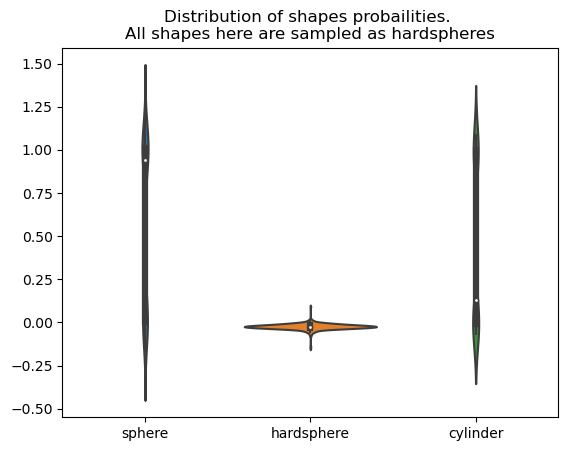

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'hardsphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as hardspheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


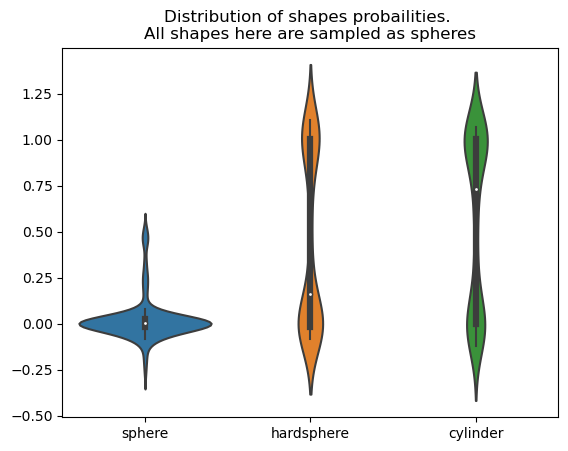

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'sphere'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

/home/slaskina/.conda/envs/ma/lib/python3.9/site-packages/seaborn/categorical.py:470: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


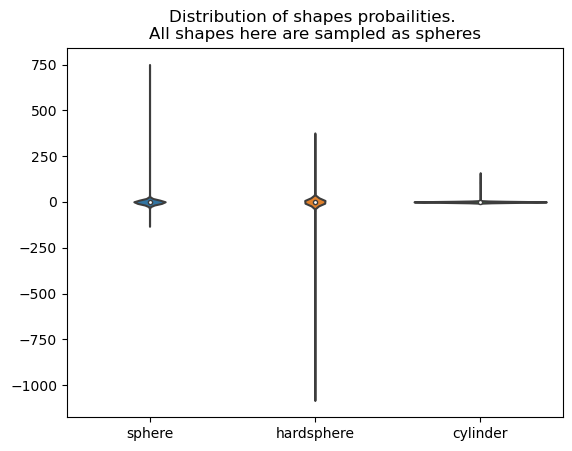

In [ ]:
sns.violinplot(unidentified_shapes[unidentified_shapes.true_class == 'cylinder'][[0,1,2]]);
plt.title('Distribution of shapes probailities. \nAll shapes here are sampled as spheres')
plt.xticks([0,1,2], list(shapes_dict.values()));

In [ ]:
unidentified_shapes

,0,1,2,true_class,prediction
0,0.022978,1.045312,0.010411,cylinder,hardsphere
1,0.162896,0.673255,-0.090661,cylinder,hardsphere
2,-0.008535,0.953166,-0.027160,cylinder,hardsphere
3,0.030299,-0.019449,0.990024,hardsphere,cylinder
4,-0.064076,0.960261,0.048948,sphere,hardsphere
...,...,...,...,...,...
1495,0.009665,-0.033105,1.012604,hardsphere,cylinder
1496,-0.009766,1.107931,-0.039471,sphere,hardsphere
1497,0.033013,1.032014,0.066133,cylinder,hardsphere
1498,-0.032073,1.026627,-0.009060,sphere,hardsphere
